# Tutorial 2 - Feature selection and extraction

## Załadowanie zbiorów danych ##

W tutorialu będziemy wykorzystywać dwa zbiory danych "breast cancer" oraz "iris". Kolejne etapy są realizowane przy użyciu jednego z nich (w większości jest to "breast cancer") niemniej jednak nazewnitwo poszczególnych zmiennych jest na tyle analogiczne, iż nie powinno być problemem ich podmienienie. Jednak to pozostawiamy ciekawości wykonującego tutorial. 

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris

In [ ]:
def load_dataset(load_function):
    raw_data = load_function()

    data = raw_data.data
    labels = raw_data.target
    features = raw_data.feature_names
    
    #tworzymy DataFrame i ustawiamy dla kolumn nazwy cech jakie reprezentują
    dataset = pd.DataFrame(data)
    dataset.columns = features
    
    return dataset, features, labels

In [ ]:
cancer_dataset, cancer_features, cancer_labels = load_dataset(load_breast_cancer)
# cancer_dataset.head()

In [ ]:
iris_dataset, iris_features, iris_labels= load_dataset(load_iris)
# iris_dataset.head()

O zbiorze breast cancer wiemy, iż label 0 oznacza nowotwór niezłośliwy, zaś 1 złośliwy - dla czytelności przemapujemy kolumnę label

In [ ]:
def func_1(x):
    if x == 0:
        return 'Benign'
    if x == 1: 
        return 'Malignant'
    
cancer_labels = np.array(list(map(func_1, cancer_labels)))
# cancer_labels

O zbiorze iris wiemy, iż wartości 0, 1, 2 odpiadając odpowiednim gatunkom Irysa: Iris Setosa, Iris Versicolour, Iris Virginica - dla czytelności przemapujemy kolumnę label

In [ ]:
def func_2(x):
    if x == 0: 
        return 'Santosa'
    if x == 1:
        return 'Versicolour'
    if x == 2:
        return 'Virginica'

iris_labels = np.array(list(map(func_2, iris_labels)))
# iris_labels

# Procedury selekcji cech

Zadaniem selekcji cech jest ograniczenie zbioru atrybutów danych. Aby jej zastosowanie poprawiło nasz model, musimy wiedzieć, dla jakich danych zastosowanie selekcji przyniesie korzyści oraz określić przydatność konkretnych atrybutów. Każdy model jest inny, ale w ogólności warto zastosować selekcję, gdy:

### Obiekty mają zbyt wiele wymiarów
    Im więcej różnych cech, tym łatwiej o przetrenowanie modelu. W ekstremalnych przypadkach, gdy atrybutów jest więcej, niż badanych obiektów, otrzymujemy idealne dopasowanie, z którego nic nie wynika.
    
### Grupa cech jest od siebie zależna
    W przypadku wysokiej korelacji między cechami, część tak samo zachowujących się atrybutów można odrzucić, gdyż obiążają one jedynie model.

### Model jest zbyt skomplikowany
    Na prostszym modelu łatwiej operować, oraz wyciągnąć z niego wnioski. Zbyt wiele atrybutów może po prostu zaciemnić nam obraz.
    
### Dane zawierają nieprzydatne atrybuty
    W przypadku, gdy obiekty posiadają cechy niezwiązane z badanym problemem (na przykład użyte do ich identyfikacji w bazie danych), pozostawienie ich do trenowania modelu zaburzy nasze wyniki zmniejszając ich jakość.


## Wyróżniamy kilka najważniejszych sposobów selekcji cech:
* usuwanie cech o niskiej wariancji - atrybuty o niskiej zmienności prawdopodobnie nie wniosą wiele do klasyfikacji. Nie należy jednak używać tej metody pochopnie i odpowiednio dobrać graniczną wariancję.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
def variance_selection(dataset, features, threshold):
    var_selector = VarianceThreshold(threshold=threshold)
    var_selector.fit(dataset, features)
    var_support = var_selector.get_support().tolist()
    
    # dane są przechowywane w tablicach numpy. Aby przefiltrować cechy, nakładamy na taką tablicę maskę uzyskaną z selekcji
    var_feature = dataset.loc[:,var_support].columns.tolist()
    return var_feature

In [ ]:
# poeksperymentuj z różnymi wartościami wariancji - weź pod uwagę, że część danych jest typu boolean a część float
cancer_reduced = variance_selection(cancer_dataset, cancer_features, .9 * (1 - .9))
print(cancer_reduced)

In [ ]:
# podane funkcje zadziałają również dla zbioru danych iris
iris_reduced = variance_selection(iris_dataset, iris_features, 0.3)
print(iris_reduced)

* usuwanie cech o wysokiej korelacji- jak wspomniano wcześniej, jeśli cechy są silnie ze sobą związane, to możemy zostawić jedną.

In [ ]:
def correlation_selection(dataset, target_feature, threshold):
    cor = dataset.corr()
    cor_target = abs(cor[target_feature])
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features
    

In [ ]:
# w tym przypadku podajemy cechę, której korelację z innymi będziemy mierzyć
cancer_reduced = correlation_selection(cancer_dataset, 'mean perimeter', 0.5)

# wynik pozostawiamy w oryginalnej formie, żeby móc zobaczyć współczynnik korelacji
# jeśli potrzebna jest lista cech, należy zastosować poniższą linijkę
# cancer_reduced = list(cancer_reduced.keys())

print(cancer_reduced)

* wybieranie cech na podstawie analizy statystycznej - po wykonaniu zadanej ilości testów stwierdzamy, które cechy najlepiej odróżniają zadane grupy danych. W poniższym przykładzie posłużymy się testem zgodności chi-kwadrat. Porównuje on wartość rzeczywistą cechy z wartością oczekiwaną na podstawie modelu a następnie ocenia ją za pomocą rozkładu chi-kwadrat.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
def chi_selection(dataset, labels, how_many):
    chi_selector = SelectKBest(chi2, k=how_many)
    chi_selector.fit(dataset, labels)
    
    # podobnie jak w przypadku metody z wariancją tworzymy maskę i nakładamy ją na zestaw cech
    chi_support = chi_selector.get_support().tolist()
    chi_feature = dataset.loc[:,chi_support].columns.tolist()
    return chi_feature

In [ ]:
cancer_reduced = chi_selection(cancer_dataset, cancer_labels, 15)
print(cancer_reduced)

* korzystanie z modeli estymujących - wstępnie przetrenowujemy na naszych danych model, który po dopasowaniu zapisze, jak przydatne były dane cechy do podjęcia decyzji. Następnie określamy próg przydatności i odrzucamy cechy poniżej tego progu.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
def model_selection(dataset, label, features):
    classifier = ExtraTreesClassifier(n_estimators=50)
    
    classifier = classifier.fit(dataset, label)
    selector = SelectFromModel(classifier, prefit=True)
    
    model_support = selector.get_support(indices=True)
    
    return features[model_support]

In [ ]:
cancer_reduced = model_selection(cancer_dataset, cancer_labels, cancer_features)
print(cancer_reduced)

* rekursywna eliminacja cech - podstawa działania taka sama, jak w powyższej metodzie. Różnica polega na tym, że rekursywnie trenujemy kolejne modele aż osiągniemy zadaną liczebność zbioru cech, zamiast pojedynczego odrzucenia wszystkich atrybutów poniżej progu


In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
def recursive_selection(dataset, label, features, howMany):
    classifier = ExtraTreesClassifier(n_estimators=50)
    selector = RFE(classifier, howMany, step=3)
    
    selector.fit_transform(dataset, label)
    recursive_support = selector.get_support(indices=True)
    
    return features[recursive_support]

In [ ]:
cancer_reduced = recursive_selection(cancer_dataset, cancer_labels, cancer_features, 10)
print(cancer_reduced)

## Wizualizacja ważności cech
Powyższe funkcje zwracają nam jedynie zadaną ilość najlepszych cech. Modele estymujące możemy jednak wykorzystać również do oszacowania ważności poszczególnych argumentów. Przedstawienie jej następnie w postaci czytelnego wykresu może pomóc nam podjąć decyzję, ile cech chcemy zachować.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
classifier = ExtraTreesClassifier(n_estimators=50)
classifier = classifier.fit(cancer_dataset, cancer_labels)

sorted_indices = np.argsort(classifier.feature_importances_)
labels = cancer_features[sorted_indices][::-1]

Y = classifier.feature_importances_[sorted_indices][::-1]
X = [i for i in range(len(labels))]

plt.figure(figsize = (16,6))
plt.bar(X, Y, tick_label=labels)
plt.xticks(rotation='vertical')
plt.show()

## Zadanie 1 -  Porównanie klasyfikacji cech

W tym punkcie sprawdzimy, jaki wpływ ma selekcja cech na wynik klasyfikacji K-NN (k-nearest neighbours). Zadanie polega na wypełnieniu poniższej tabelki wartościami zwróconymi przez funkcję k_classify dla określonych parametrów. K oznacza, ilu najbliższych sąsiadów będzie brał pod uwagę przy klasyfikacji, m natomiast jak wiele cech weźmiemy pod uwagę, gdzie n oznacza cały zbiór.\
Należy użyć zbioru danych breast_cancer, gdyż iris nie posiada wystarczającej ilości atrybutów.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
def select_random_features(m, features):
    mask = np.random.choice(np.arange(len(features)), size=m, replace=False)
    return features[mask]

In [ ]:
def k_classify(k, dataset, selected_features, target):
    reduced_dataset = dataset[selected_features]
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    test_results = cross_val_score(classifier, reduced_dataset, target)
    return test_results.mean()

In [ ]:
# miejsce na własny kod, użyj jednej z podanych wcześniej funkcji selekcjonujących
# uważaj, żeby nie nadpisać istniejących zmiennych

# Liczenie macierzy kowariancji
Elementami macierzy kowariancji są współczynniki kowariancji dla par zmiennych losowych opisanych przez parametry wiersza i kolumny macierzy. Macierz ta jest przeniesieniem pojęcia wariancji na przypadek wielowymiarowy. 
Zastosowanie:  Pozwala ona stwierdzić, czy jakieś cechy są od siebe zależne.
Stórzmy macierz kowariancji:

In [ ]:
cov = iris_dataset.cov()
#cov

W interpretacji pomoże nam heatmap

In [ ]:
import seaborn as sns
sns.heatmap(cov)

Im wyższa wartość, tym większa kowariancja. Dla przykładu długość płatka (petal) kompletnie nie zależy od szerokości kielicha (sepal), ale im dłuższy jest płatek tym dłuższy jest kielich. 

# PCA - principal component analysis
### Motywacja
   Do tej pory selekcja cech, którą wykonywaliśmy polegała na wyborze podzbioru cech, które najbardziej wpływały na rozróżnialność obiektów. Co jeśli cechy, które najpiej pozwalają je rozróżniać nie stanowią podzbioru wszystkich cech, a zbiór  ich określonych kombinacji liniowych? Dla zobrazowania posłuże się przykładem.
   Mamy dany trywialny zbiór danych o dwóch cechach (x i y), jesli te potraktujemy jako wektory z bazy kanonicznej mamy mniej wiecej taki obrazek:
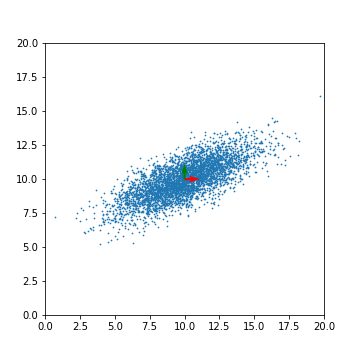
Do tej pory gdybyśmy chcieli dokonać selekcji cech wybralibyśmy cechę x za tę skojarzoną z największą wariancją - oczywiście przy tak małej liczbie cech tak się nie robi, jednak to tylko przykład. 

Widać, że największa wariancja jest położona wzdłóż zupełnie innego wektora (na rysunku poniżej wektor czerwony). Druga cecha również powinna się zmienić, gdyż chcemy uniknąć zależności między wektorami cech (aby uniknąć nadmiarowości):
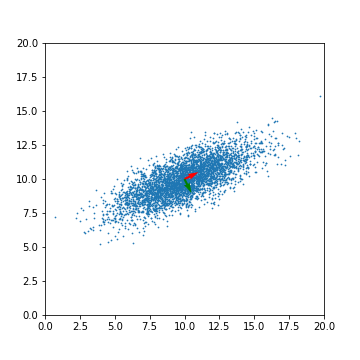
Należy zuważyć ze wektor czerwony jest bardziej znaczący, co możemy podkreślić zmieniając jego długość:
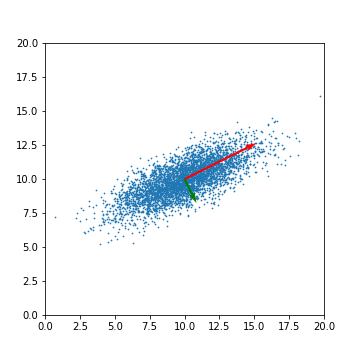
Gdybyśmy z nowego zestawu cech usunęli wektor zielony utracilibyśmy mniej informacji aniżeli w poprzednim przypadku.

Wyobraźmy sobie że mamy zbiór danych, ktory ma nie dwie cechy, a kilkadziesiąt. Teoretycznie moglibyśmy odrzucić takie najmniej znaczące cechy, nie tracąc zbytnio na ilości posiadanych informacji potrzebnych do rozróżniania obiektów.





## Singular Value Decomposition

Powyżej opisana procedura to zgrubsza to co robi PCA. Jednak, aby lepiej zrozumieć "jak" najpierw należy poznać SVD.

Singular value decomposition (SVD) czyli rozkład według wartości własnych jest to jeden ze sposobów na dekompozcyje macierzy (w naszym wypadku tą macierzą jest macierz złożona z danych)

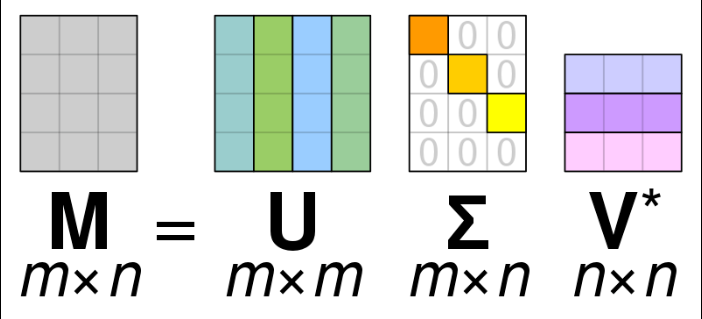

Szczególnie istotna jest tu macierz sigma. Jest ona diagonalna, a na przekątnej znajdują się kolejne wartości własne macierzy wyjściowej uporządkowane malejąco. Co ważne kazdej z tych wartości odpowiada taki wektor jak na ostanim rysunku w poprzednim przykładzie.

## PCA

Co tak właściwie robi transformacja PCA? Wykonuje SVD po czym w macieży sigma pozostawia jedynie k największych wartości własnych.

Z punktu widzenia praktycznego pozwala:
- znaleźć zestaw cech najbardziej istotnych - od teraz cecha to wektor cech (tych danych z zbiorze), którego kolejne współczynniki okreslają stopień udziału konkretnej cechy w tej nowostworzonej
- skutecznie ograniczyć liczbę wymiarów usuwając tylko najmniej istotne z punktu widzenia klasyfikacji
- przy odpowiednio dużej redukcji wymiaru pozwala na wizualizację

## Do dzieła! - czyli o tym jak tego dokonać



### Rozpoczniemy od znormalizowania danych, następnie wykonanamy na nich tranformacje PCA.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

x = cancer_dataset.loc[:, cancer_features].values
x = StandardScaler().fit_transform(x)
x

In [ ]:
from sklearn.decomposition import PCA

# tworzymy obiekt tranformacji PCA, tutaj liczba nowych cech równa liczbie cech wyjściowych, ale może być mniejsza
pca = PCA(n_components=30)

cancer_pca = pca.fit_transform(x)

# cancer_pca to nowa macież danych - w kolumnach znajdują się nowe cechy, w wierszach obiekty w kolejności wyjściowej
cancer_pca

### GOTOWE! 

### Poniżej narysowany został histogram wag (wartości własnych) kolejnych nowych cech nazwanych f0 - f29. Zgodnie z zapowiedzią kolejne cechy mają coraz mniejsze wartości własne.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,6))
plt.bar( ['f' + str(i) for i in range(30)], pca.singular_values_)
plt.show()

### Ocena jakości klasyfikatora

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, cancer_dataset.loc[:, cancer_features].values, cancer_labels, cv=loo)
print('Accuracy: %0.2f' % scores.mean())

## Zadanie 2
### Należy zbadać jakość klasyfikatorów k-nn (dla k = 1, 3, 5) dla zestawu m najlepszych "starych" cech (m = N, 5, 2) , oraz dla zestawu m najlepszych "nowych" cech (m = N, 5, 2). Wyniki zaprezentować w tabelkach.
Preferowany do obliczeń jest zbiór "breast cancer" niemniej jednak we własnym zakresie można również sprawdić zbiór "iris", należy jednak pamietać, że całkowita liczba cech w tym zbiorze wynosi 4.

_     |               m najlepszych starch cech                |             nowe m najlepszych nowych cech             |
      |       m = N      |       m = 5      |       m = 2      |       m = N      |       m = 5       |       m = 2     |
k = 1 |                  |                  |                  |                  |                   |                 |
k = 3 |                  |                  |                  |                  |                   |                 |
k = 5 |                  |                  |                  |                  |                   |                 |

In [ ]:
def get_score(dataset, features, labels, m, k):
    x = dataset.loc[:, features].values
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=m)
    pca_res = pca.fit_transform(x)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    loo = LeaveOneOut()
    scores = cross_val_score(knn, pca_res, labels, cv=loo)
    return scores.mean()

In [ ]:
# miejsce na twój kod :D 

### Wizualizacja zbioru danych

Trasformacja PCA może również służyć do skutecznej redukcji wymiarów. Gdy liczbę wymiarów zredukujemy do dwóch łatwo będzie można przestawić dane na wykresie. 

Dodatkowo warto znaleźć outliery. Outliery to punkty, które są odległe od innych obserwowanych punktów. Outliery możemy znaleźć przy pomocy `Z-Score`. Standardowo outlierami określane są punkty, których wartość `Z-Score` jest większya od `3`. 

Poniżej zaprezentowano taką wizualizację dla zbioru "breast cancer":

In [ ]:
x = cancer_dataset.loc[:, cancer_features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
cancer_pca = pca.fit_transform(x)

cancer_dataset_pca = pd.DataFrame(data = cancer_pca, columns = ["p1", "p2"])

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('p1',fontsize=20)
plt.ylabel('p2',fontsize=20)
targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = cancer_labels == target
    plt.scatter(cancer_dataset_pca.loc[indicesToKeep, 'p1'] , cancer_dataset_pca.loc[indicesToKeep, 'p2'], c = color, s = 50)
    
    
# plot outliers
from scipy import stats
z = np.abs(stats.zscore(cancer_dataset_pca))
threshold = 3
cancer_dataset_pca_outliers = cancer_dataset_pca[(z > threshold).all(axis=1)]
plt.scatter(cancer_dataset_pca_outliers['p1'] , cancer_dataset_pca_outliers['p2'], c = 'b', s = 50)
        
plt = plt.legend(targets + ['outliers'],prop={'size': 15})


In [ ]:
# from scipy import stats
# print(cancer_dataset_pca)
# z = np.abs(stats.zscore(cancer_dataset_pca))
# print(len(z))
# threshold = 3
# print(np.where(z > 3))
# cancer_dataset_pca_outliers = cancer_dataset_pca[(z > 3).all(axis=1)]
# print(cancer_dataset_pca_outliers)


# plt.scatter(cancer_dataset_pca_outliers['p1'] , cancer_dataset_pca_outliers['p2'], c = 'b', s = 50)
# print(cancer_dataset_pca_outliers['p1'])

### ZADANIE: W zbiorach MNIST, NMIST, CIFAR-10 .
a. znaleźć NAJMNIEJ INFORMATYWNE cechy (piksele). Zobrazować je na rysunku, wielkością odpowiadającemu klasyfikowanym obrazkom.\
b. Dokonać klasyfikacji k-nn na pełnym zbiorze i zbiorze bez m najmniej informatywnych cech. \
c. Przetransformować zbiory przy pomocy PCA z N-D do N-D. Jak wyglądają (obrazki) wektory własne odpowiadające największym wartością własnym. Sprawdzić, czy poprawił się wynik klasyfikacji. Dokonać wizualizacji 2-D przy pomocy PCA. \
d. Usunąć m najmniej informatywnych cech PCA. Jak wygląda wynik klasyfikacji. \
e. Wybrac m NAJLEPSZYCH cech PCA. Jak wygląda teraz wynik klasyfikacji. \
f. Wartość m w przypadku wyboru najgorszych cech ma być duże (dla N=784 jakieś m=500), w przypadku wyboru najlepszych małe (m=10-20) \
g. Dokonać klasyfikacji z PCA i bez PCA (na pełnym zbiorze cech i zadanym małym M), ale zwiększając ilość przykładów przy pomocy augmentacji (imgaug). \
h. Wnioski (co lepsze augmentacja czy inżynieria cech?)\


#### Ładowanie MNIST oraz FMNIST

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 28, 28)

    return images, labels

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)

def show_imgs(imgs):
    ia.imshow(np.hstack(iaa.Resize(size=10.0).augment(images=imgs)))

In [ ]:
fmnist_images, fmnist_labels = load_mnist('datasets/FMNIST')
fmnist_classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

show_imgs(fmnist_images[0:10])
print([fmnist_classes[i] for i in fmnist_labels[0:10]])

#### Ładowanie CIFAR-10

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
cifar_10_batch1 = unpickle('datasets/CIFAR-10/cifar-10-batches-py/data_batch_1')
cifar_10_meta = unpickle('datasets/CIFAR-10/cifar-10-batches-py/batches.meta')

show_imgs(np.transpose(cifar_10_batch1.get(b'data').reshape(10000, 3, 32, 32)[0:10], axes=[0, 2, 3, 1]))
print([cifar_10_meta.get(b'label_names')[i] for i in cifar_10_batch1.get(b'labels')[0:10]])

In [ ]:
#miejsce na własny kod